# Exercise 4 - Image classification with Feature Maps

In this exercise you will learn how feature maps can be used improve the accuracy of image classifiers based on softmax regression.



### Submission

- Deadline of submission:
        x.y.z
- Mail your solution notebook or a link to your gitlab repository (with the solution notebook inside) to:
        paul.kahlmeyer@uni-jena.de

In the event of a persistent problem, do not hesitate to contact the course instructors.

In [1]:
# General
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Softmax Regression

In this classification task we have more than two classes, therefore we use *softmax regression* as the natural extension of logistic regression (see exercise 2).

Recall, that in softmax regression we have features $x\in\mathbb{R}^n$ which we want to classify into $m$ classes.
The goal is then to find a matrix $\theta\in\mathbb{R}^{n\times m}$, so that

\begin{equation}
p(y=i|x) = \cfrac{\exp\left(x^T\theta^{(i)}\right)}{\sum_{j=1}^{m}\exp\left(x^T\theta^{(j)}\right)}
\end{equation}

where $\theta^{(i)}$ is the i-th column of $\theta$.

## Dataset

For this exercise we use a preprocessed subset of a dataset for [Scene Classification](https://www.kaggle.com/nitishabharathi/scene-classification). All images are 128x128 grayscale images from one of three classes:
- Buildings
- Forest
- Mountains

The goal of this exercise is to train classifiers that can classify images into their respective scenery.

### Task 1

The dataset is stored as numpy arrays under `X.npy` (images) and `Y.npy` (labels).

Load the dataset and display an image per class using matplotlib.

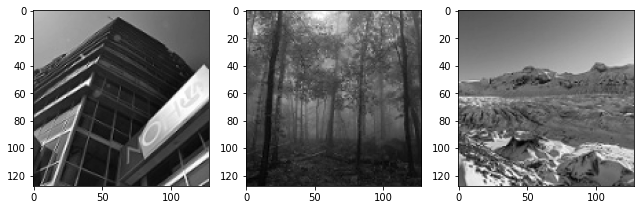

In [2]:
# TODO: Load dataset and display images
X = np.load('X.npy')
Y = np.load('Y.npy')

fs = 3
n_classes = 3
fig, axs = plt.subplots(nrows=1, ncols=n_classes, figsize=(3*fs,fs))
for i in range(n_classes):
    imgs = X[Y==i]
    img = imgs[np.random.randint(imgs.shape[0])]
    axs[i].imshow(img.reshape((128,128)), cmap='gray')
plt.tight_layout()

## No feature map

### Task 2

In scikit-learn, softmax regression is implemented within the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class. 

Use scikit learn to fit softmax regression on the images and evaluate the accuracy on train- and test data.
What do you observe?

Hint: 
- Use the keyword "multinomial"

In [3]:
# TODO: Split data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# TODO: fit softmax regression + get accuracy on train- and test data
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42).fit(X_train,Y_train)
train_acc = np.sum(regressor.predict(X_train) == Y_train)/Y_train.shape[0]
test_acc = np.sum(regressor.predict(X_test) == Y_test)/Y_test.shape[0]
train_acc, test_acc

C:\Users\Paul Kahlmeyer\anaconda3\envs\statlearn\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.968, 0.44)

Observation: Overfitting

## Hand crafted features

You probably observed, that softmax regression on the raw pixel values does not lead to good results.

One way to improve this is to derive features from the images first. Here, we want to use the approach of deriving a **Bag of Visual Words** (BoVW) from our images. See [here](https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb) for a nice description.

### Task 3

In a first step, we need to extract features from our images. Here we want to use ORB features, that are basically a free to use variant to the more famous SIFT features. 
In Python the package OpenCV (`pip install opencv-python`) provides this functionality.

Install OpenCV and use it to detect ORB keypoints on one of the training data. Plot the image with the detected keypoints.

Hints:
- See [here](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html) for an example usage of an ORB detector
- See [here](https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html) for information on detector parameters
- You can acess the coordinates of a keypoint `kp` with `kp.pt`

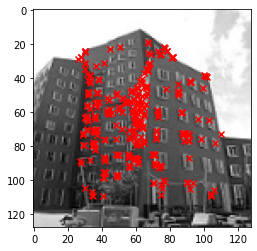

In [4]:
# TODO: load image
x = X_train[0]
img = (x.reshape((128,128))).astype(np.uint8)

# TODO: compute keypoints
import cv2
# Initiate ORB detector
orb = cv2.ORB_create(edgeThreshold = 15, nfeatures=400)
# Compute Keypoints
kp, desc = orb.detectAndCompute(img, None)

# TODO: 
# plot on image
x_values = [p.pt[0] for p in kp]
y_values = [p.pt[1] for p in kp]
plt.imshow(img, cmap='gray')
plt.scatter(x_values, y_values, color='red', marker='x')

###  Task 4

Each keypoint not only has a location, but also an array of length 32 that describes it (descriptor).

Calculate the descriptors of your train data and store them in a single array.

Hints:
- Use `detectAndCompute` to not only get the locations, but also the descriptors of the keypoints

In [5]:
# TODO: collect descriptors of keypoints of train data

# find keypoints in dataset
descs = []
for x in X_train:
    img = (x.reshape((128,128))).astype(np.uint8)
    kp, desc = orb.detectAndCompute(img, None)
    if desc is not None:
        descs.append(desc)
descs = np.concatenate(descs, axis=0)
descs.shape

(668195, 32)

### Task 5
In a second step, we want to get the main visual words from our set of descriptors. 
Here we will simply use [kmeans](https://en.wikipedia.org/wiki/K-means_clustering) to cluster the descriptors and take the resulting cluster centres as visual words.

Use the [KMeans class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from scikit learn to cluster the descriptors into 30 clusters of visual words.

In [6]:
# TODO: use kmeans to cluster the descriptors
from sklearn.cluster import KMeans
# cluster keypoints using kmeans #clusters = #visual features
nwords = 30
kmeans = KMeans(n_clusters=nwords,random_state=0,n_init=3)
kmeans.fit(descs)

KMeans(n_clusters=30, n_init=3, random_state=0)

### Task 6

With our clustering at hand, we can assign a single descriptor to a single visual word.

Load an image of the trainset, calculate the descriptors and classify them into the visual words. Additionaly visualize the result of the assignments (e.g. by using a bar chart).

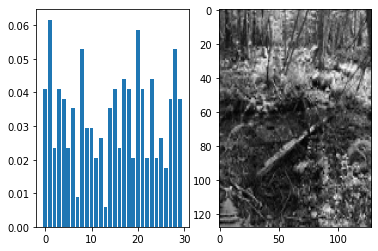

In [7]:
# TODO: classify descriptors of an image, visualize results

x = X_train[10]
img = (x.reshape((128,128))).astype(np.uint8)
kp, desc = orb.detectAndCompute(img, None)
pred = kmeans.predict(desc)
hist = [np.sum(pred==k)/pred.shape[0] for k in range(nwords)]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].bar(np.arange(nwords), hist)
axs[1].imshow(img, cmap='gray',aspect="auto")

### Task 7

Classify the descriptors of all the images in the trainset into visual words.

Store the resulting classifications relative frequencies, that is for each image $x$ store the vector

\begin{equation}
\left[\cfrac{\text{Number descriptors classified as }i}{\text{Number of descriptors}}\right]_{i=1,\dots,\text{Number visual words}}
\end{equation}

In [8]:
# TODO: calculate relative frequencies of visual words on trainset
hists_train = []
fails = []
for i,x in enumerate(X_train):
    img = (x.reshape((128,128))).astype(np.uint8)
    kp, desc = orb.detectAndCompute(img, None)
    if desc is None:
        fails.append(i)
    else:
        pred = kmeans.predict(desc)
        hist = [np.sum(pred==k)/pred.shape[0] for k in range(nwords)]
        hists_train.append(hist)
hists_train = np.array(hists_train)

### Task 8
We can now use the relative frequencies of visual words on the trainset together with the knowledge of labels to classify our testset.

Here you will implement a k-nearest-neighbour (KNN) classificator, where a classification of an image $x$ is done with the following steps:

1. Calculate the descriptors of the keypoints of $x$
2. Classify the descriptors into visual words, calculate relative frequencies
3. Compare frequencies to frequencies of the trainset
4. Take the labels of the k most similar frequencies
5. Classify into the most occuring label among the k selected labels


To perform this classification, implement two functions: 

- a distance measure to compare frequencies of visual words
- a classification function, that wraps up the steps above

Hints: 
- [Here](https://stats.stackexchange.com/questions/7400/how-to-assess-the-similarity-of-two-histograms) you can find several examples for distance measures
- use numpys [argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) for determining KNN

In [9]:
def dist(freq1, freq2):
    # TODO: Implement a distance measure
    return np.mean((freq1-freq2)**2)

def classify(x, freqs_train, Y_train, k=20):
    # TODO: Implement KNN classification
    img = (x.reshape((128,128))).astype(np.uint8)
    kp, desc = orb.detectAndCompute(img, None)
    pred = kmeans.predict(desc)
    hist_x = np.array([np.sum(pred==i)/pred.shape[0] for i in range(nwords)])
    
    dists = [dist(hist_x, h) for h in freqs_train]
    idx = np.argsort(dists)[:k]
    idx_labels = Y_train[idx]
    
    return np.argmax([np.sum(idx_labels==i) for i in range(n_classes)])

Now classify your testset. What is your accuracy?

In [10]:
# TODO: classify testset
preds = [classify(x, hists_train, Y_train) for x in tqdm(X_test)]
acc = np.sum(np.array(preds)==Y_test)/Y_test.shape[0]
acc

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 35.85it/s]


0.5906666666666667

## Deep Learning Features

In practice, Deep Learning features are the state of the art for most image classification tasks.

Mostly a neural net is trained as a feature map that converts images into deep learning feature vectors, which are then classified by softmax regression.

### Task 9

We want to use the deep learning library Pytorch to evaluate how suitable deep learning features are for our image classification task.

Visit the the Pytorch [website](https://pytorch.org/) and install the pytorch package (select your install version and use the provided command). Make sure you can execute the imports below.

In [11]:
# TODO: make sure you can import this
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

### Task 10

Pytorch works with `torch.tensor` objects. They are essentialy numpy arrays with a gradient attribute.
In order to feed our data into a Pytorch neural network, we have to provide a wrapper for our dataset. 

All we have to do is to inherit from the `torch.utils.data.Dataset` class and define two functions:

- `__getitem__`: This provides the functionality to index the dataset with [ ]
- `__len__`: This specifies the size of our dataset

Implement the two functions in the class `MyDataset`.

Hints:
- You can cast a numpy array to a tensor using `torch.as_tensor`
- You can cast a torch tensor `x` to a different datatype using `x.float()`, `x.double()`,...

In [12]:
class MyDataset(Dataset):
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        # TODO: return image (float tensor) and label (long tensor) at index
        
        label = self.Y[index]
        image = self.X[index]
        
        return torch.as_tensor(image).float(), torch.as_tensor(label).long()

    def __len__(self):
        # TODO: return length of dataset
        
        return self.X.shape[0]

### Task 11

Now create a train- and testset instance of the `MyDataset` class.

Use these instances to define [DataLoaders](https://pytorch.org/docs/stable/data.html) with a specified batchsize.

In [13]:
# TODO: create MyDataset Testset, Trainset
# Transform data into Tensor that has a range from 0 to 1
train_set = MyDataset(X_train/255, Y_train)
test_set = MyDataset(X_test/255, Y_test)

# TODO: create DataLoaders
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

### Task 12

Next we define the neural net that we want to use. Below you can find a predefined class. The heart of the definition is the `forward` function, which defines how an input is propagated trough the network.

In this example, we first reshape the input into its image form (with `x.view`).
Then we feed it trough a series of Convolutional layers followed by MaxPooling layers.
Last, we flatten the output (again with `x.view`) and feed it trough to fully connected layers. 

See the [documentation](https://pytorch.org/docs/stable/nn.html) for more information on the specific layers.


Note, that layer6 is the equivalent to our softmax regression. The weights of layer6 correspond to our $\theta$ matrix, 
the activation function performs the softmax operation.

Execute the definition below and create an instance of `MyNN`.

In [14]:
class MyNN(nn.Module):
    
    def __init__(self):
        super(MyNN, self).__init__()
        
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.act1 = nn.ReLU()
        # output shape: 16x124x124
        
        self.layer2 = nn.MaxPool2d(kernel_size=2)
        # output shape: 16x62x62
        
        self.layer3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5)
        self.act3 = nn.ReLU()
        # output shape: 8x58x58
        
        self.layer4 = nn.MaxPool2d(kernel_size=2)
        # output shape: 8x29x29
        
        self.layer5 = nn.Linear(in_features=8*29*29, out_features=100)
        self.act5 = nn.Sigmoid()
        
        self.layer6 = nn.Linear(in_features=100, out_features=n_classes)
        self.act6 = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        out = x.view(x.shape[0],1,128,128)
        out = self.layer1(out)
        out = self.act1(out)
        
        out = self.layer2(out)
        
        out = self.layer3(out)
        out = self.act3(out)
        
        out = self.layer4(out)
        out = out.view(out.shape[0], -1)
        
        out = self.layer5(out)
        out = self.act5(out)
        
        out = self.layer6(out)
        out = self.act6(out)
        return out

In [15]:
# TODO: create instance of MyNN
model = MyNN()

### Task 13

We have the Dataset and the neural network. Now we want to train it.

Use the [tutorial on CIFAR10 classification](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) to set up a training loop. After each iteration trough the training set, compute the accuracy on the test data. Store these accuracies as well as the losses.

In [16]:
# TODO: Set up train loop

error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


num_epochs = 10

# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for train, labels in train_loader:
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    

        loss_list.append(loss.data.item())
    
        # Testing the model
    
    total = 0
    correct = 0

    for images, labels in test_loader:

        outputs = model(images)
        predictions = torch.max(outputs, 1)[1]
        correct += (predictions == labels).sum()

        total += len(labels)        
    accuracy = correct / total
    accuracy_list.append(accuracy.item())
        
    print(f"Epoch: {epoch}, Loss: {round(loss_list[-1],2)}, Accuracy: {round(accuracy_list[-1],2)}")

Epoch: 0, Loss: 0.9, Accuracy: 0.68
Epoch: 1, Loss: 0.88, Accuracy: 0.72
Epoch: 2, Loss: 0.79, Accuracy: 0.77
Epoch: 3, Loss: 0.75, Accuracy: 0.78
Epoch: 4, Loss: 0.73, Accuracy: 0.8
Epoch: 5, Loss: 0.8, Accuracy: 0.81
Epoch: 6, Loss: 0.69, Accuracy: 0.83
Epoch: 7, Loss: 0.67, Accuracy: 0.83
Epoch: 8, Loss: 0.66, Accuracy: 0.82
Epoch: 9, Loss: 0.63, Accuracy: 0.85


### Task 14

Train your neural net for **10 epochs**, plot the losses and the accuracies. How high can you get the accuracy?

Hints:
- Normalize the input values to be in $[0,1]$
- Try different [optimizers](https://pytorch.org/docs/stable/optim.html)
- Feel free to change the parameters in `MyNet` or to use different layers

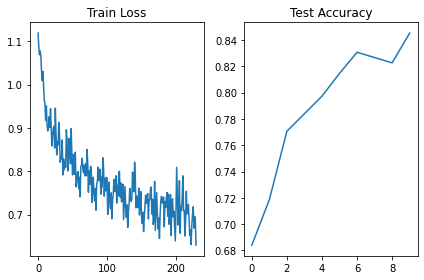

In [18]:
# TODO: plot losses and accuracies
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(loss_list)
axs[1].plot(accuracy_list)
axs[0].set_title('Train Loss')
axs[1].set_title('Test Accuracy')
plt.tight_layout()